
# $\ell_1$-norm Wavelet for Sparse MRI

In this notebook, we will create an L1 wavelet regularized reconstruction from scratch.

## Setup

Let us import relevant packages and load the 10-channel heart dataset.

In [97]:
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import h5py
import fastmri
from fastmri.data.transforms import to_tensor
import torch
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [98]:
def center_crop(ksp):
    c, h, w = ksp.shape
    F = sp.linop.FFT(ksp.shape, axes=(-1, -2))
    img = F.H * ksp
    img = img[:, :, (w-h)//2:(w+h)//2]
    F = sp.linop.FFT(img.shape, axes=(-1, -2))
    return F * img

In [99]:
def plotmxn(images, m, n ,names=None, cmap = 'gray'):
    '''plot a mxn image
    param:
        images: tensor, shape [c, h, w]
        m: int, number of rows
        n: int, number of columns
    '''
    fig, axes = plt.subplots(m, n, layout='compressed', figsize=(2.5*n, 2.5*m))
    for i in range(m):  
        for j in range(n):
            if names:
                axes[i,j].set_title(names[i][j])
            axes[i,j].imshow(np.abs(images[i+j]), cmap=cmap)
            
def plot1x2(images, cmap = 'gray'):
    fig, axes = plt.subplots(1, 2, layout='compressed', figsize=(8, 4))
    axes[0].set_title('Reconstructed image')
    axes[0].imshow(abs(images[0]), cmap=cmap)
    axes[1].set_title('Original image')
    axes[1].imshow(np.abs(images[1]), cmap=cmap)

In [100]:

path = './data/P001-T1map_0_0.h5'
with h5py.File(path, 'r') as file:
    dataset = file[list(file.keys())[0]]
    ksp = dataset[:]
ksp = center_crop(ksp)
print(ksp.shape)
ksp = to_tensor(ksp)
ksp = (ksp[...,0] + 1j*ksp[...,1]).numpy()
img_shape = ksp.shape[1:]

(10, 144, 144)


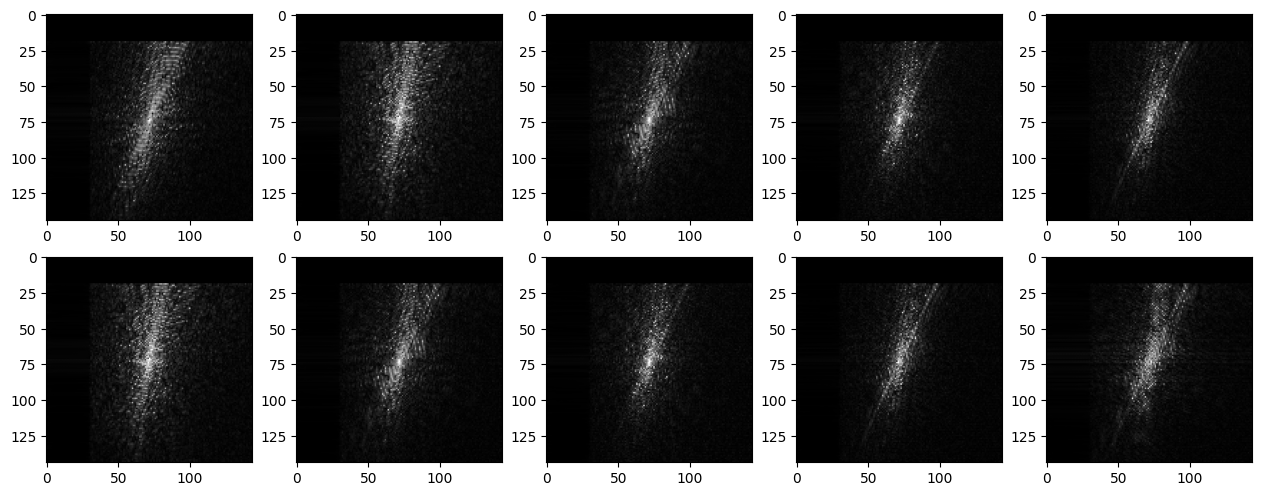

In [101]:
plotmxn(np.log1p(10e3 * ksp), 2, 5)

Get random Cartesian undersampling mask.

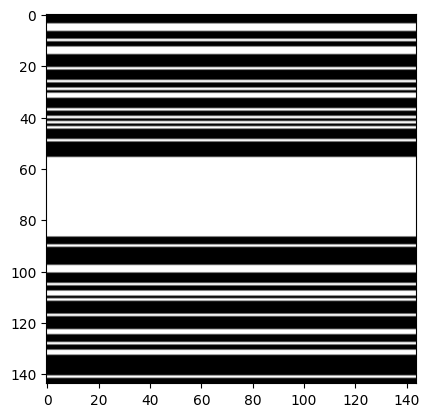

In [102]:
from fastmri.data.subsample import create_mask_for_mask_type

def create_mask(shape, num_acs, accelerate):
    '''
        param:
        - shape: eg: (256, 256)
        - num_acs: eg:16, 22,
        - accelerateL: eg: 4,8
    '''
    center_fractions = num_acs / shape[0]
    mask_func = create_mask_for_mask_type(
            'random', [center_fractions], [accelerate]
        )
    mask, num_low_frequencies = mask_func(shape=[1, shape[0], shape[1]],seed=42)  # mask shape: [1, 256, 1]
    
    one_metrix = torch.ones((shape[0], shape[1]))
    mask = np.array(one_metrix * mask[0,...])
    
    return mask

mask = create_mask(shape=(144, 144), num_acs=30, accelerate=2.4)
plt.imshow(mask, cmap="gray")

## Define Linear operator

To start, we will create an FFT $F$ Linear operator.

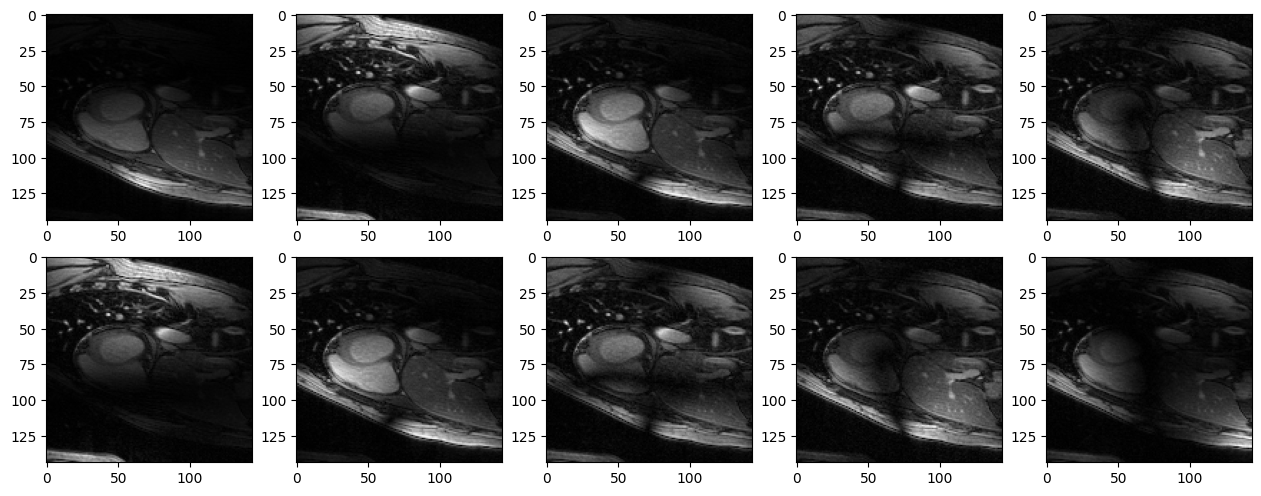

In [103]:
F = sp.linop.FFT(ksp.shape, axes=(-1, -2))
plotmxn(F.H * ksp, 2, 5)

The next  we will create is the sensitivity maps operator $S$.

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

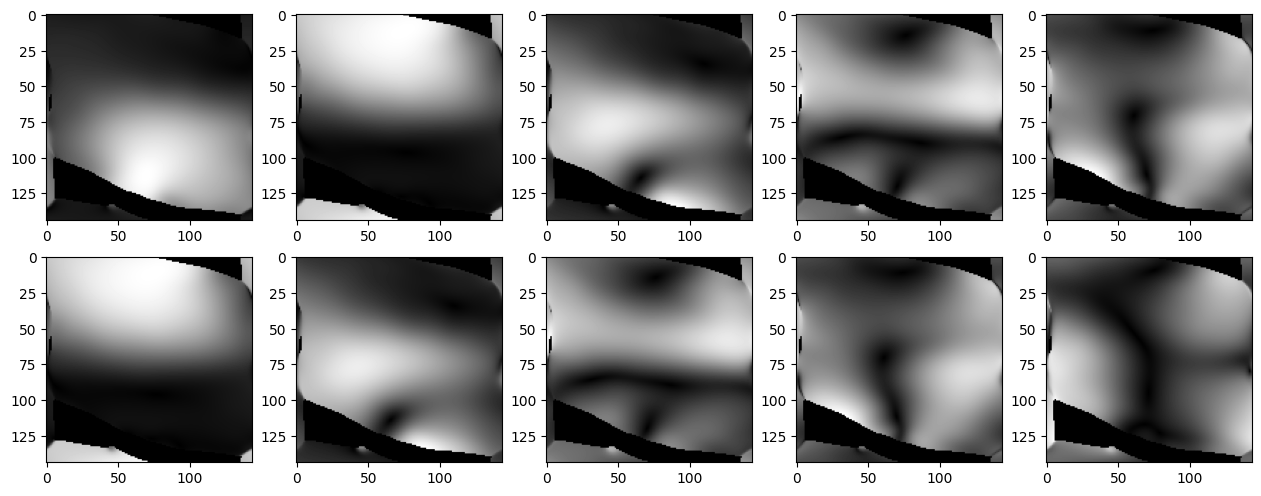

In [104]:
mps = mr.app.EspiritCalib(ksp, 24).run()
S = sp.linop.Multiply(img_shape, mps)
plotmxn(mps, 2, 5)
# pl.ImagePlot(mps, z=0, title=r'$sens map$')

Get Target image

线圈数为$k$，$x_k$为每个线圈的图像域数据，那么目标图像可以表示为：$rsos = (\sum x_k^2)^{1/2}$

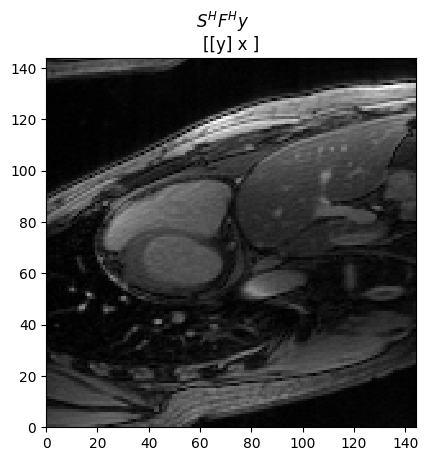

In [105]:
from monai.apps.reconstruction.mri_utils import root_sum_of_squares as rss
target2 = rss(np.abs(F.H * ksp) ,0)
pl.ImagePlot(rss(np.abs(F.H * ksp) ,0), title=r'$S^H F^H y$')

The sampling operator is also similar to the sensitivity maps operator: Given the sampling mask, this is multiplication undersampling operator $P$.

Get zero filling image.

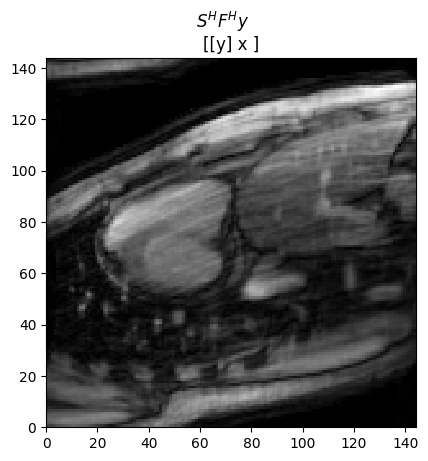

In [106]:
P = sp.linop.Multiply(ksp.shape, mask)
zf = S.H * F.H * P.H * ksp
pl.ImagePlot(zf, title=r'$S^H F^H y$')

Define Wavelet transform

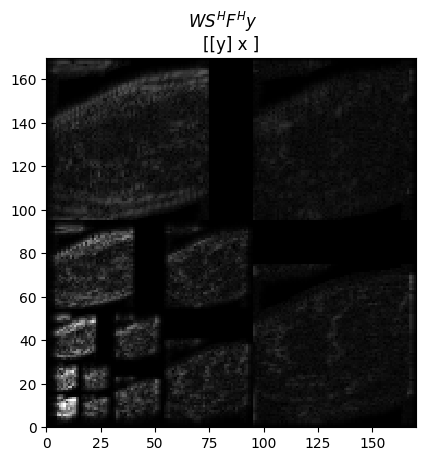

In [107]:
W = sp.linop.Wavelet(img_shape)
wav = W * S.H * F.H * ksp
pl.ImagePlot(wav**0.5, title=r'$W S^H F^H y$')

In [108]:
A = P * F * S * W.H

In [109]:
from sigpy import backend, util

In [110]:

class GradientMethod(object):
    r"""First order gradient method."""

    def __init__(
        self,
        gradf,
        x,
        alpha,
        proxg=None,
        accelerate=False,
        max_iter=100,
        tol=0,
    ):
        self.gradf = gradf
        self.alpha = alpha
        self.accelerate = accelerate
        self.proxg = proxg
        self.x = x
        self.tol = tol
        self.max_iter = max_iter
        self.iter = 0

        self.device = backend.get_device(x)

        self.resid = np.infty

    def update(self):
        xp = self.device.xp
        
        
        with self.device:
            x_old = self.x.copy()

            # Perform update
            util.axpy(self.x, -self.alpha, self.gradf(self.x))  # TODO: update z: z += (-a z)
            if self.proxg is not None:
                backend.copyto(self.x, self.proxg(self.alpha, self.x)) # TODO: 软阈值

            self.resid = xp.linalg.norm(self.x - x_old).item() / self.alpha
        self.iter += 1

    def done(self):
        return (self.iter >= self.max_iter) or self.resid <= self.tol

In [111]:
import numba as nb


@nb.vectorize  # pragma: no cover
def soft_thresh(lamda, input):
    r"""Soft threshold.

    Performs:

    .. math::
        (| x | - \lambda)_+  \text{sgn}(x)

    Args:
        lamda (float, or array): Threshold parameter.
        input (array)

    Returns:
        array: soft-thresholded result.

    """
    
    abs_input = abs(input)
    if abs_input == 0:
        sign = 0
    else:
        sign = input / abs_input

    mag = abs_input - lamda
    mag = (abs(mag) + mag) / 2

    return mag * sign


class L1Reg(object):
    r"""Proximal operator for l1 regularization.

    .. math::
        \min_x \frac{1}{2} \| x - y \|_2^2 + \lambda \| x \|_1

    Args:
        shape (tuple of ints): input shape
        lamda (float): regularization parameter

    """

    def __init__(self, shape, lamda):
        self.lamda = lamda
        self.shape = list(shape)

        
    def __call__(self, alpha, input):
        try:
            output = self._prox(alpha, input)
        except Exception as e:
            raise RuntimeError("Exceptions from {}.".format(self)) from e

        return output

    def _prox(self, alpha, input):
        return soft_thresh(self.lamda * alpha, input)
        
        

In [112]:
lamda = 0.0000003
max_iter = 300  # 最大迭代轮数
alpha = 1  # 步长

class L1WaveletRecon(sp.app.App):
    def __init__(self, ksp, mask, mps, lamda, max_iter):
        img_shape = mps.shape[1:]
        
        S = sp.linop.Multiply(img_shape, mps)
        F = sp.linop.FFT(ksp.shape, axes=(-1, -2))
        P = sp.linop.Multiply(ksp.shape, mask)
        self.W = sp.linop.Wavelet(img_shape)
        A = P * F * S * self.W.H
        
        proxg = L1Reg(A.ishape, lamda)
        
        self.wav = np.zeros(A.ishape, np.complex)
        def gradf(x):
            return A.H * (A * x - P*ksp)

        alg = GradientMethod(gradf, self.wav, alpha, proxg=proxg, 
                                    max_iter=max_iter)
        super().__init__(alg)
        
    def _output(self):
        return self.W.H(self.wav)

In [113]:
mask = np.array(mask)

/var/folders/nb/93b9_2ln7dldysmzrr_9n4y00000gn/T/ipykernel_6595/224807982.py:17: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.wav = np.zeros(A.ishape, np.complex)


L1WaveletRecon:   0%|          | 0/300 [00:00<?, ?it/s]

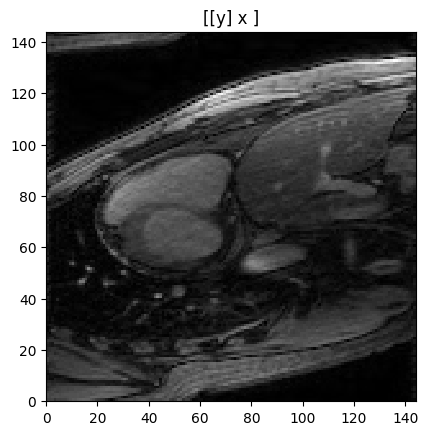

In [114]:
img = L1WaveletRecon(ksp, mask, mps, lamda, max_iter).run()
pl.ImagePlot(img)

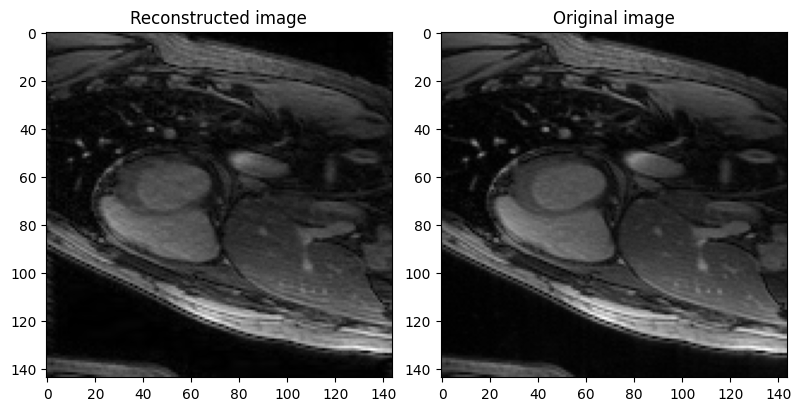

In [115]:
plot1x2(np.stack((img, target2), axis=0))

In [116]:
from skimage.metrics.simple_metrics import peak_signal_noise_ratio
def normalize(img):
    img = np.abs(img)
    _range = (img.max() - img.min())
    if _range != 0:
        return (img - img.min()) / _range
    else:
        return img
    
def PSNR(org, recon):
    """
    org: dim=3 or dim=2, [c,nx,ny] or [nx,ny], np.array
    recon: dim=3 or dim=2
    """
    org = normalize(org)
    recon = normalize(recon)
    if org.ndim == 3:
        return np.mean(
            [
                peak_signal_noise_ratio(org[i], recon[i], data_range=org[i].max())
                for i in range(org.shape[0])
            ]
        )
    else:
        return peak_signal_noise_ratio(org, recon, data_range=org.max())
PSNR(img, np.array(target2))

32.54889951159027